# Determining if two documents are written by the same author

In [17]:
import pickle
import numpy as np
import data_prep as dp
import similarity_measures as sm
import imposter_meth as im
import corpus_class as cp


import matplotlib.pyplot as plt
%matplotlib inline


# Corpus- Class

In [22]:
text1 = 'First example'
text2 = 'Next example'
text3 = 'Third example'
text4 = 'Four example'

cor = cp.corpus([text1, text3], [text2, text4])
cor.build_matrix()
print(cor.get_pair(0))

[array([ 0.        ,  0.        ,  0.        ,  0.23104906,  0.        ,
        0.        ,  0.        ,  0.        ,  0.23104906,  0.        ]), array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.27725887])]


Gives back the tf-idf vector representations of text 1 and 2

# Imposters

Because it takes a couple of minutes to compute the algorithm for 500 pairs, I just load the results:

In [3]:
with open('/Users/alexandersauer/Anaconda_Projects/results/scores500_blog', 'rb') as f:
    scores_blog = pickle.load(f)
with open('/Users/alexandersauer/Anaconda_Projects/results/scores500_minmax', 'rb') as f:
    scores_minmax = pickle.load(f)
with open('/Users/alexandersauer/Anaconda_Projects/results/scores500_cosine', 'rb') as f:
    scores_cos = pickle.load(f)
    

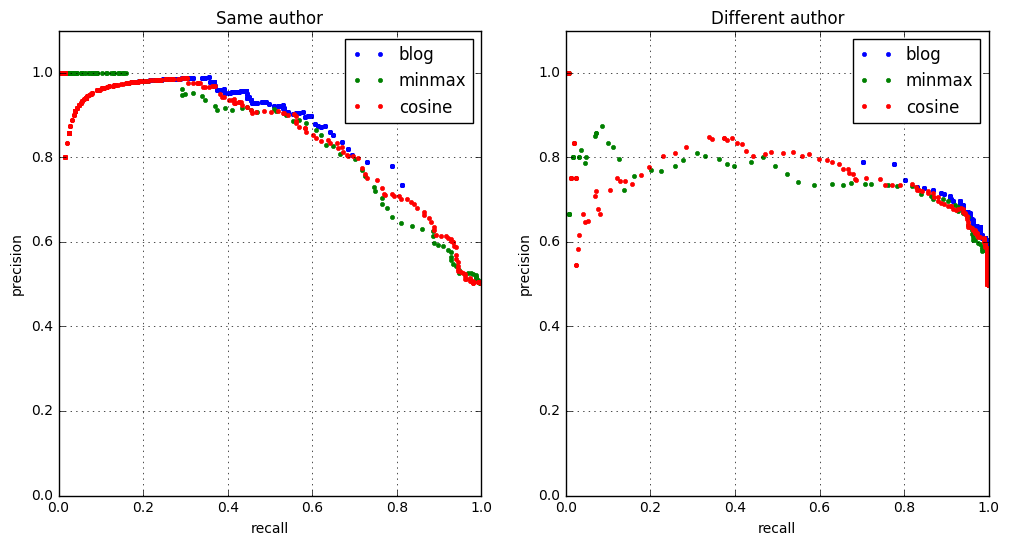

In [12]:
alg_dec = im.p_r_dic(scores_blog)
min_dec = im.p_r_dic(scores_minmax)
cos_dec = im.p_r_dic(scores_cos)

bsame_prec = [alg_dec[sigma][0] for sigma in alg_dec.keys()]
bsame_rec = [alg_dec[sigma][1] for sigma in alg_dec.keys()]
bdiff_prec = [alg_dec[sigma][2] for sigma in alg_dec.keys()]
bdiff_rec = [alg_dec[sigma][3] for sigma in alg_dec.keys()]


msame_prec = [min_dec[sigma][0] for sigma in min_dec.keys()]
msame_rec = [min_dec[sigma][1] for sigma in min_dec.keys()]
mdiff_prec = [min_dec[sigma][2] for sigma in min_dec.keys()]
mdiff_rec = [min_dec[sigma][3] for sigma in min_dec.keys()]

csame_prec = [cos_dec[sigma][0] for sigma in cos_dec.keys()]
csame_rec = [cos_dec[sigma][1] for sigma in cos_dec.keys()]
cdiff_prec = [cos_dec[sigma][2] for sigma in cos_dec.keys()]
cdiff_rec = [cos_dec[sigma][3] for sigma in cos_dec.keys()]

plt.figure(1, figsize= (12,6))
plt.subplot(1,2,1)
plt.plot(bsame_rec, bsame_prec, '.', msame_rec, msame_prec, '.', csame_rec, csame_prec, '.')
plt.legend(['blog', 'minmax', 'cosine'])
plt.axis([0,1,0,1.1])
plt.title('Same author')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

plt.subplot(1,2,2)
plt.plot(bdiff_rec, bdiff_prec, '.', mdiff_rec, mdiff_prec, '.', cdiff_rec, cdiff_prec, '.')
plt.legend(['blog', 'minmax', 'cosine'])
plt.axis([0,1,0,1.1])
plt.title('Different author')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid()

## No difference! - WHY?!

# Algorithms


1. Generate a set of impostors $Y_1, . . . , Y_m$.
2. Compute $score_X(Y)$ = the number of choices of feature sets (out of 100) for which $sim(X, Y) > sim(X, Y_i)$, for all $i = 1, . . . , m$.
3. Repeat the above with impostors $X_1, . . . , X_m$ and compute scoreY(X) in an analogous manner.
4. If $average(score_X(Y), score_Y(X))$ is greater than a threshold $s*$, assign 〈X, Y〉 to same-author.

In [ ]:
def blog_same_author(x,y,text_corpus, threshold, nr_imposters = 25, return_score = False):
    '''Return true if x and y are by the same author according to the algorithm in the paper'''
    imposters_y = imposters(y, text_corpus.Y, n = nr_imposters)
    score_xy = get_score(x,y,imposters_y, sm.cminmax)
    
    imposters_x = imposters(x, text_corpus.X, n = nr_imposters)
    score_yx = get_score(y,x,imposters_x, sm.cminmax)
    
    if return_score == True:
        return (score_xy + score_yx ) /2.0

    if (score_xy + score_yx ) /2.0 > threshold:
        return True
    else:
        return False


## Create Blog-universe
1. Compute the min-max similarity to Y of each document in the universe. Select the m most similar documents as potential impostors.
2. Randomly select n actual impostors from among the potential impostors.

In [ ]:
def imposters(y, universe, m = 250, n = 25):
    '''Return n imposters. Compute the m most similar files in universe and randomly select n from them '''
    minmax_vec = np.array([sm.cminmax(t,y) for t in universe])
    pot_imp_ind = minmax_vec.argsort()[:-(m+1):-1] # Last m entries
    pot_imp_ind = np.sort(np.random.choice(pot_imp_ind, n))
    return [universe[k] for k in pot_imp_ind[::-1]]  # Have the most similar imposters first, to hope for a quicker break in the get_score algorithm
    

## Compute Score

Compute $score_X(Y)$ = the number of choices of feature sets (out of 100) for which $sim(X, Y) > sim(X, Y_i)$, for all $i = 1, . . . , m$.

In [ ]:
@jit
def get_score(x,y,imposters,sim):
    '''Compute for how many random feature sets out of 100 sim(x,y) is greater than sim(x,z) for all z in imposters'''	
    score = 0
    sim_xy = sim(x,y) 
    for k in range(100):
        ran_el = np.sort(np.random.choice(range(len(x)), (1,round(len(x) / 2)), replace = False))      # Sorting makes the next steps faster  
        c_x = x[ran_el][0]
        c_y = y[ran_el][0]
        sim_xy = sim(c_x,c_y)


        for yi in imposters:
            if sim(c_x, np.take(yi,ran_el)[0]) > sim_xy:        # If there is one text in imposter with a greater score, there is no need to continue
                break
        else:
            score += 1

    return score / 100.0  # 

Algorithms to store the results and compute precision and recall:

In [ ]:
def result_array(corp, sigma= None):
    '''
    Returns an array with tuples containing the average score given by the algorithms whether both
    texts are by the same author and a boolean whether the pair really is by the same author    
    '''
    res = []
    for k in range(corp.get_length()):
        alg = blog_same_author(*corp.get_pair(k), corp, threshold = sigma, return_score = True)
        same_author = corp.same_author(k)
        res.append((alg, same_author))
    return res

In [ ]:
def pre_recall(result_array, threshold):
    ''' Return precision and recall values for the same-author and different-author classes'''
    same_same, same_dif, dif_same, dif_dif = 0,0,0,0
    for k in range(len(result_array)):
        res = (result_array[k][0] > threshold )
        same_author = result_array[k][1]
        
        if same_author and res:
            same_same += 1
        if same_author and not res:
            same_dif +=1
        if not same_author and res:
            dif_same +=1
        if not same_author and not res:
            dif_dif +=1
    try:
        precision_same = same_same / (same_same + dif_same)
        recall_same = same_same / (same_same + same_dif)

        precision_dif = dif_dif / (same_dif + dif_dif)
        recall_dif = dif_dif / (dif_dif + dif_same)

        acc = (same_same + dif_dif) / len(result_array)
    except ZeroDivisionError:
        return None

    return precision_same, recall_same, precision_dif, recall_dif, acc 


In [ ]:
def p_r_dic(result_array):
    '''Create a dictionary with threshold values and the decisions based on this threshold'''
    s_range = np.linspace(0, 0.8, 1000)
    res = {}
    for sigma in s_range:
        pc = pre_recall(result_array, sigma)
        if pc == None:
            continue
        res[sigma] = pre_recall(result_array, sigma)
    return res